## Notebook for Figure 7 and related content: Analysis of cryopreserved cells from T1D donors. Alpha cell dysfunction and beta-cell survival
### Author: J. Camunas-Soler
### Last Updated: Feb. 2020

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
from singlet.dataset import Dataset
from singlet import SampleSheet, CountsTable
%matplotlib inline

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [3]:
%run ./../functions/helper_functions.py

#### Load Data and definitions

In [4]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total Exocitosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [5]:
root_folder = './../data/'
analysis_folder = './../analysis/'
fig_folder = './../figures/fig7_suppfig7/'

In [6]:
#Load and reformat patch-seq dataset
filename =  root_folder + 'patchclamp_wcryo_human.counts.tab'
metadata = root_folder + 'patchclamp_wcryo_human.metadata.tab'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv(analysis_folder + 'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder +'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')

annotation.rename(columns=dict_phenotype_norm, inplace=True)
#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

#remove genes not seen in 5 cells or having 10 counts total
test= filter_genes_pp(test, min_cells=5, min_counts=10)
#create dataset
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
#remove nans in glucse
ds.samplesheet = ds.samplesheet[~ds.samplesheet[['Glucose_mM']].isnull().values]
#save unnormalized table
ds_pclamp_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_norm = ds.copy()
ds_norm.counts = ds_norm.counts.normalize()
ds_norm.counts.pseudocount = 1
ds_norm.counts = ds_norm.counts.log(base=2)
ds_norm.counts.pseudocount = 1
ds_norm_pclamp = ds_norm.copy()

filter_condition = {'Cryopreserved': ['Yes']}
ds_t1d = filter_samplesheet(ds_norm, filter_dict= filter_condition)

filter_condition = {'Cryopreserved': ['No']}
ds_pclamp = filter_samplesheet(ds_norm, filter_dict= filter_condition)

#### tSNE Figure 7 and stats

In [7]:
pos_tsne = pd.read_csv(analysis_folder + 'tsne_coord_cryo_t1d.csv', sep='\t',index_col=0)
df_tsne = pd.concat([pos_tsne, ds_t1d.samplesheet[['cell_type','DiabetesStatus','DonorID']]],axis=1).dropna().sort_values(by='cell_type')

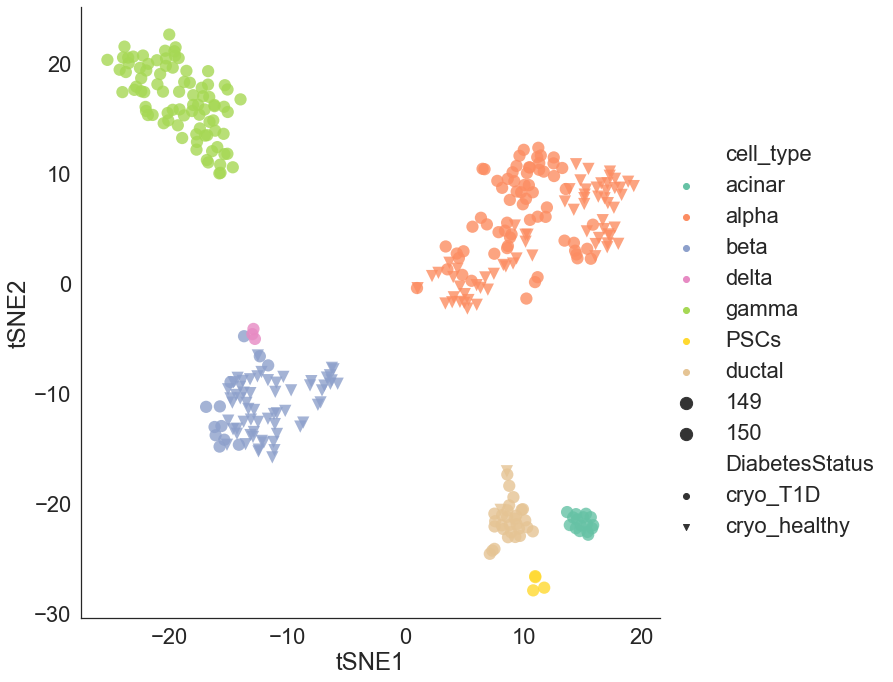

In [8]:
sns.set(font_scale=2)
sns.set_style("white")
soft_palette = sns.color_palette(['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854'])
soft_palette = sns.color_palette(['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854',
'#ffd92f',
'#e5c494'])

fig = sns.relplot( x="tSNE1", y="tSNE2", data=df_tsne, hue='cell_type', 
                  hue_order=['acinar','alpha','beta','delta','gamma','PSCs','ductal'],
                  size=150,sizes=(150,150), style='DiabetesStatus',
           palette=soft_palette,aspect=1,height=10,linewidth=0,markers= ["o",  "v", "p"],alpha=0.8)
#plt.legend(loc='upper right',)
#plt.tight_layout(h_pad=0.01)
fig.savefig(fig_folder+'/fig7a.pdf', dpi=300)

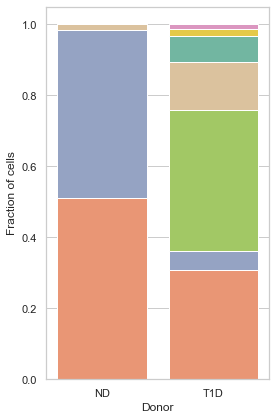

In [9]:
df_tsne['Donor'] = df_tsne['DonorID'].map({'cryo_R079_T1D': 'T1D', 'cryo_R119_T1D': 'T1D', 'cryo_R132_T1D': 'T1D',
'cryo_R177': 'ND', 'cryo_R134': 'ND', 'cryo_R124': 'ND'})
res = df_tsne.groupby('Donor')['cell_type'].value_counts()#).rename()#.pivot()
res = res.reset_index(name='cnt').pivot(index='cell_type', columns='Donor',values='cnt').fillna(0)
new_order = ['alpha', 'beta',  'gamma', 'ductal', 'acinar','PSCs','delta']
new_order2 = ['T1D', 'ND']
donor_sum = res.sum(axis=0)
res = res.loc[new_order,new_order2].cumsum(axis=0) / res.sum(axis=0)

res = res.T.reset_index()

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(4, 6))
soft_palette = sns.color_palette(['#e78ac3','#ffd92f','#66c2a5','#e5c494','#a6d854','#8da0cb','#fc8d62'])

# Plot the total crashes
#sns.set_color_codes("Pastel")
cell_types = ['delta','PSCs', 'acinar','ductal','gamma','beta', 'alpha' ]
for i,cell_type in enumerate(cell_types):
    sns.barplot(x="Donor", y=cell_type, data=res,
                label="Total", color=soft_palette[i])
ax.set_ylabel('Fraction of cells')
f.tight_layout()
f.savefig(fig_folder+'fig_7a_inset.pdf')

In [10]:
donor_sum

Donor
ND     133.0
T1D    215.0
dtype: float64

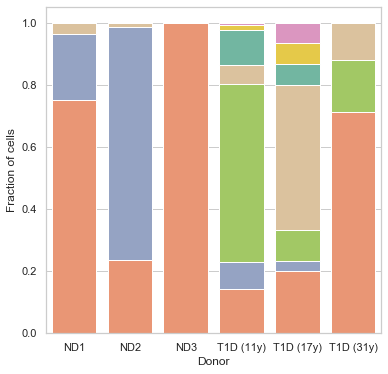

In [11]:
df_tsne['Donor'] = df_tsne['DonorID'].map({'cryo_R079_T1D': 'T1D (17y)', 'cryo_R119_T1D': 'T1D (11y)', 'cryo_R132_T1D': 'T1D (31y)',
'cryo_R177': 'ND1', 'cryo_R134': 'ND2', 'cryo_R124': 'ND3'})
res = df_tsne.groupby('Donor')['cell_type'].value_counts()#).rename()#.pivot()
res = res.reset_index(name='cnt').pivot(index='cell_type', columns='Donor',values='cnt').fillna(0)
new_order = ['alpha', 'beta',  'gamma', 'ductal', 'acinar','PSCs','delta']
new_order2 = ['T1D (11y)', 'T1D (17y)', 'T1D (31y)','ND1', 'ND2', 'ND3']
donor_sum = res.sum(axis=0)
res = res.loc[new_order,new_order2].cumsum(axis=0) /res.sum(axis=0)#.sum(axis=0)

res = res.T.reset_index()#.melt()

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))
soft_palette = sns.color_palette(['#e78ac3','#ffd92f','#66c2a5','#e5c494','#a6d854','#8da0cb','#fc8d62'])

# Plot the total crashes
#sns.set_color_codes("Pastel")
cell_types = ['delta','PSCs', 'acinar','ductal','gamma','beta', 'alpha' ]
for i,cell_type in enumerate(cell_types):
    sns.barplot(x="Donor", y=cell_type, data=res,
                label="Total", color=soft_palette[i])
ax.set_ylabel('Fraction of cells')
f.savefig(fig_folder +'suppfig_7c.pdf')

In [12]:
donor_sum

Donor
ND1           28.0
ND2           76.0
ND3           29.0
T1D (11y)    126.0
T1D (17y)     30.0
T1D (31y)     59.0
dtype: float64

#### Ephys Comparisons in Fig7 and Supp Fig 7

In [13]:
filter_condition = { 'cell_type': ['alpha','beta','gamma','ductal','acinar','delta','PSCs'],
    'Cryopreserved':['Yes'],
                   'Patched': ['Yes']}

pars = ['Cell size','Total Exocitosis',
 'Late exocytosis',
 'Early exocytosis',
 'Exocytosis norm Ca2+',
 'Ca2+ entry',
 'Early Ca2+ current',
 'Late Ca2+ current',
 'Late Ca2+ Conductance',
 'Peak Na+ current',
 'Na+ conductance']

def df_get_mu_pvals(df, pars, column_class='DiabetesStatus',categories=['healthy','T2D']):    
    from scipy.stats import mannwhitneyu
    from scipy.stats import ks_2samp
    from statsmodels.sandbox.stats.multicomp import multipletests
    pvals ={}
    for par in pars:
        cond1= df[column_class]==categories[0]
        group1 = df[cond1][par].dropna()
        cond2= df[column_class]==categories[1]
        group2 = df[cond2][par].dropna()
        pvals[par] = mannwhitneyu(group1, group2, use_continuity=True, alternative=None)[1]

        pvals =pd.Series(pvals)
    pvals =pd.DataFrame(pvals,columns=['pval'])
    pvals['FDR']= multipletests(pvals['pval'], method='fdr_bh')[1]
    return pvals

#this uexports normalized counts for Mann-Whitney
ts = filter_samplesheet(ds_t1d, filter_dict= filter_condition)
#remove a comma from data
ts.samplesheet[pars] = ts.samplesheet[pars].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
ts.samplesheet[pars] = ts.samplesheet[pars].astype(float)
groups_rename={'cryo_healthy':'ND','cryo_T1D':'T1D'}
ts.samplesheet['DiabetesStatus'].replace(groups_rename, inplace=True)
ts.samplesheet['condition'] = ts.samplesheet['cell_type']+' '+ts.samplesheet['DiabetesStatus']

ts.samplesheet['DiabetesStatus'].replace(groups_rename, inplace=True)

groupby_col = 'condition'
groups = ['cryo_healthy','cryo_T1D']
thres=2


cols = pars + [groupby_col]

qlow=0.
qhigh=0.97


x = filter_quantile_values(ts.samplesheet, columns=pars, qlow=qlow,qhigh=qhigh)
for par in pars:
    if x[par].mean() < 0:
        x[par] = -1*(x[par])
    #clip value of electrophysiology to zero, no negative values
    x[par] = x[par].clip(lower=0)

t = x[cols]


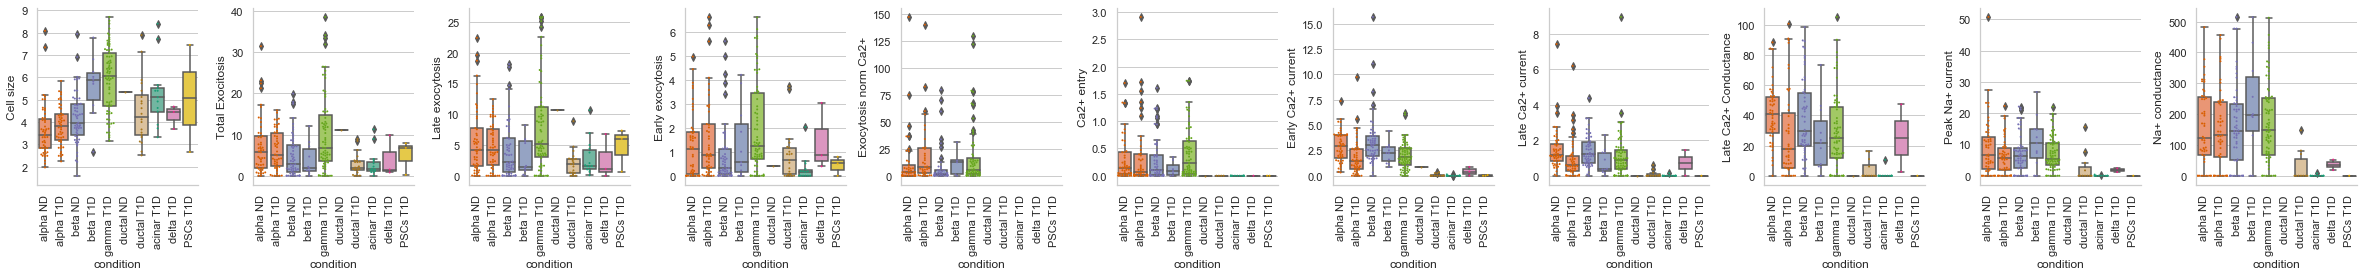

In [14]:
#avoid filter warning in seaborn plotting
np.warnings.filterwarnings('ignore')

fig,axs= plt.subplots(nrows=1,ncols=11,figsize=(33,4))
axs = axs.flatten()
order_ct = [ 'alpha ND','alpha T1D', 'beta ND', 'beta T1D','gamma T1D', 'ductal ND',  'ductal T1D','acinar T1D',
        'delta T1D', 'PSCs T1D']

new_order = ['alpha', 'beta',  'gamma', 'ductal', 'acinar','PSCs','delta']

order_ct = [ 'alpha ND','alpha T1D', 'beta ND', 'beta T1D','gamma T1D', 'ductal ND',  'ductal T1D','acinar T1D',
        'delta T1D', 'PSCs T1D']

softer_palette = sns.color_palette(['#fdcdac','#fdcdac','#cbd5e8','#cbd5e8','#e6f5c9','#f1e2cc','#f1e2cc','#b3e2cd','#f4cae4','#fff2ae'])
dark_palette = sns.color_palette(['#d95f02','#d95f02','#7570b3', '#7570b3', '#66a61e','#a6761d','#a6761d','#1b9e77','#e7298a','#e6ab02'])
soft_palette = sns.color_palette(['#fc8d62','#fc8d62','#8da0cb','#8da0cb', '#a6d854','#e5c494','#e5c494','#66c2a5','#e78ac3','#ffd92f'])


for i,par in enumerate(pars):
    sns.boxplot(y=par, data=t,x='condition',ax=axs[i],palette=soft_palette,order=order_ct)
    sns.swarmplot(y=par, data=t,x='condition',ax=axs[i], palette=dark_palette,size=2,order=order_ct)
    axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)

sns.despine()
fig.tight_layout()
fig.savefig(fig_folder +'suppfig7d.pdf')

In [15]:
filter_condition = {'cell_type': ['alpha'],
                    'Cryopreserved':['Yes'],
                   'Patched': ['Yes']}

#this uexports normalized counts for Mann-Whitney
ts = filter_samplesheet(ds_t1d, filter_dict= filter_condition)
ts.samplesheet[pars] = ts.samplesheet[pars].astype(float)

groupby_col = 'DiabetesStatus'
groups = ['cryo_healthy','cryo_T1D']
groups_rename={'cryo_healthy':'ND','cryo_T1D':'T1D'}
thres=2
pars = ['Total Exocitosis',
 'Late exocytosis',
 'Early exocytosis',
 'Exocytosis norm Ca2+',
 'Ca2+ entry',
 'Early Ca2+ current',
 'Late Ca2+ current',
 'Late Ca2+ Conductance',
 'Peak Na+ current',
 'Na+ conductance']

cols = pars + [groupby_col]

qlow=0.03
qhigh=0.97

x = filter_quantile_values(ts.samplesheet, columns=pars, qlow=qlow,qhigh=qhigh, include_quantiles=False)
for par in pars:
    if x[par].mean() < 0:
        x[par] = -1*(x[par])
    #clip value of electrophysiology to zero, no negative values
    x[par] = x[par].clip(lower=0)

#mask zero values
#x[pars] = x[pars].mask(x[pars]<=0)
#prepare melted dataset
t = x[cols]

t[groupby_col].replace(groups_rename, inplace=True)

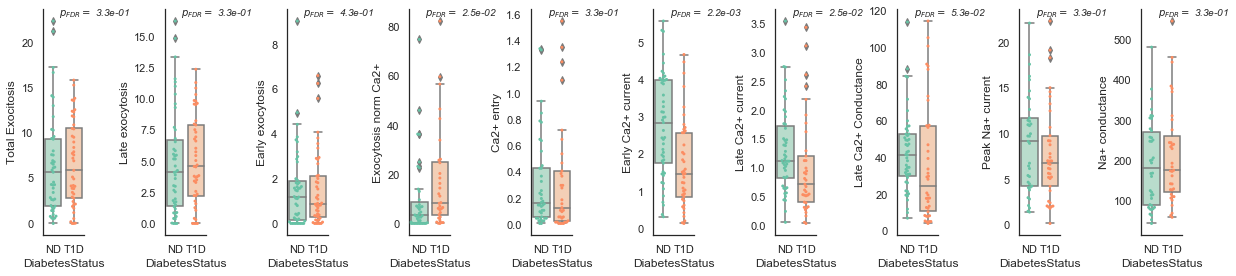

In [16]:

sns.set(font_scale=1)
sns.set_style('white')

fig,axs= plt.subplots(nrows=1,ncols=10,figsize=(17,4))
axs = axs.flatten()


pvals = df_get_mu_pvals(t, pars=pars, column_class='DiabetesStatus',categories=['ND','T1D'])
for i,par in enumerate(pars):
    sns.boxplot(y=par, data=t,x='DiabetesStatus',ax=axs[i],palette='Pastel2',order=['ND','T1D'])
    sns.swarmplot(y=par, data=t,x='DiabetesStatus',ax=axs[i], palette='Set2',size=3,order=['ND','T1D'])
    axs[i].text(0.4,0.97, r'$p_{{FDR}}=$ {:.1e}'.format(pvals.loc[par,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder + 'fig_7f.pdf') 

#### QC cryopreserved patch-seq samples

In [17]:
#pick cells to show, sort them and make palette based on a property
filter_condition = {'Cryopreserved':['No'],
                   'Patched': ['Yes'],
                   'TimefromDispersion_days': [1,2,3,4],
                     'Glucose_mM': [1,5,10],
                   'preincubation': ['No','Yes'],
                    'cell_type': ['alpha', 'beta', 'other', 'acinar', 'gamma', 'delta'],
                   'species': ['human']}
g1 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)


filter_condition = {'cell_type': ['ductal', 'gamma', 'beta', 'acinar', 'alpha', 'PSCs',
       'delta'],
                    'DiabetesStatus': ['cryo_healthy','cryo_T1D'],
                   'Patched': ['Yes']}
g2 = filter_samplesheet(ds_t1d, filter_dict= filter_condition)

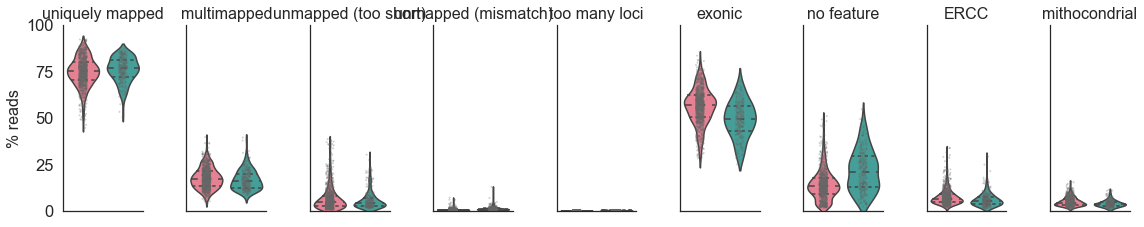

In [18]:
## plot with STAR QC /HTSEQ
sns.set(font_scale=1.5)
sns.set_style('white')
groupby_col = 'group'
genes = [ 'STAR_percent_uniquely_mapped',
 'STAR_percent_multiple_loci',
         'STAR_percent_unmapped_too_short',
 'STAR_percent_unmapped_too_many_mismatches',
        'STAR_percent_too_many_loci','percent_mapped',
 'percent_nofeature',
         'percent_ercc',
 'percent_mito']

rename_col = { 'STAR_percent_uniquely_mapped':'uniquely mapped',
 'STAR_percent_multiple_loci':'multimapped',
 'STAR_percent_too_many_loci':'too many loci',
 'STAR_percent_unmapped_too_many_mismatches':'unmapped (mismatch)',
 'STAR_percent_unmapped_too_short':'unmapped (too short)',
              'percent_mapped':'exonic',
              'percent_nofeature':'no feature',
 'percent_ercc':'ERCC',
            'percent_mito': 'mithocondrial'
              }

n_par = len(genes)
n_size = 1.8 * n_par
fig,axs= plt.subplots(nrows=1, ncols=n_par, figsize=(n_size,3.5),sharey=True)
axs=axs.flatten()
sns.set_style("whitegrid")

s1 = g1.samplesheet.loc[:,genes].copy()
s1['group'] ='Patch-clamp'
s2 = g2.samplesheet.loc[:,genes].copy()
s2['group'] ='FACS'

plot_test = pd.concat([s1,s2],axis=0)
plot_test= plot_test.rename(columns=rename_col)
#plot_test_melted = plot_test.melt()

cols_plot = plot_test.drop(columns='group').columns.tolist()
c = plot_test.melt(id_vars=groupby_col, value_vars=cols_plot,var_name='gene')

for i,gene in enumerate(c.gene.unique()):
    axs[i] = sns.violinplot(x='group', y=gene, data=plot_test,  ax=axs[i], cut=1, linewidth=1.5,palette='husl',inner='quartile',scale='width')#sns.hls_palette(2, l=.9, s=0.7))#color=".8",
    axs[i] = sns.stripplot(x='group', y=gene, data=plot_test, jitter=True, alpha=0.3, ax=axs[i],color='0.4',s=2)
    axs[i].set_title(gene,fontsize='16')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_xticklabels(['',''])
    axs[i].set_ylim(0,100)
    axs[i].set_yticks([0,25,50,75,100])
axs[0].set_ylabel('% reads',fontsize=16)
plt.yticks(fontsize=14)
#axs[9].remove()
sns.despine()
fig.tight_layout(w_pad=-1.5)
fig.savefig(fig_folder +'SuppFig7a_STAR_metrics.pdf', dpi=300)

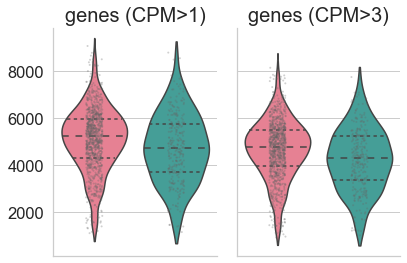

In [19]:
## plot with number of genes
groupby_col = 'group'
genes=['n_genes_1','n_genes_3']

rename_col = { 'n_genes_1': 'genes (CPM>1)',
              'n_genes_3': 'genes (CPM>3)'}

n_par = len(genes)
n_size = 3 * n_par
fig,axs= plt.subplots(nrows=1, ncols=int(n_par/2)+1, figsize=(n_size,4),sharey=True)
axs=axs.flatten()
sns.set_style("whitegrid")

s1 = g1.samplesheet.loc[:,genes].copy()
s1['group'] ='fresh'
s2 = g2.samplesheet.loc[:,genes].copy()
s2['group'] ='cryopreserved'

plot_test = pd.concat([s1,s2],axis=0)
plot_test= plot_test.rename(columns=rename_col)
#plot_test_melted = plot_test.melt()

cols_plot = plot_test.drop(columns='group').columns.tolist()
c = plot_test.melt(id_vars=groupby_col, value_vars=cols_plot,var_name='gene')

for i,gene in enumerate(c.gene.unique()):
    axs[i] = sns.violinplot(x='group', y=gene, data=plot_test,  ax=axs[i], cut=1, linewidth=1.5,palette='husl',inner='quartile',scale='width')#sns.hls_palette(2, l=.9, s=0.7))#color=".8",
    axs[i] = sns.stripplot(x='group', y=gene, data=plot_test, jitter=True, alpha=0.3, ax=axs[i],color='0.4',s=2)
    axs[i].set_title(gene,fontsize='20')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_xticklabels(['',''])
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder +'SuppFig7a_genes_metrics.pdf')

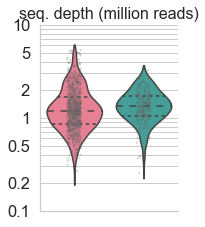

In [20]:
## plot with sequencing depth

genes = ['STAR_input_reads']
rename_col = { 'STAR_input_reads': 'seq. depth (million reads)'}

n_par = len(genes)
n_size = 3 * n_par
fig,axs= plt.subplots(nrows=1, ncols=1, figsize=(n_size,3.5),sharey=True)
sns.set_style("whitegrid")

s1 = g1.samplesheet.loc[:,genes].copy()
s1['group'] ='Patch-clamp'
s2 = g2.samplesheet.loc[:,genes].copy()
s2['group'] ='FACS'

plot_test = pd.concat([s1,s2],axis=0)
plot_test = plot_test.rename(columns=rename_col)
#plot_test_melted = plot_test.melt()
plot_test['seq. depth (million reads)'] = np.log10(plot_test['seq. depth (million reads)'])
cols_plot = plot_test.drop(columns='group').columns.tolist()
c = plot_test.melt(id_vars=groupby_col, value_vars=cols_plot,var_name='gene')

for i,gene in enumerate(c.gene.unique()):
    axs = sns.violinplot(x='group', y=gene, data=plot_test,  ax=axs, cut=1, linewidth=1.5,palette='husl',inner='quartile',scale='width')#sns.hls_palette(2, l=.9, s=0.7))#color=".8",
    axs = sns.stripplot(x='group', y=gene, data=plot_test, jitter=True, alpha=0.3, ax=axs,color='0.4',s=2)
    axs.set_title(gene,fontsize='16')
    axs.set_ylabel('')
    axs.set_xlabel('')
    axs.set_xticklabels(['',''])
    yticks_locs = list(np.linspace(1e5,1e6, 10))
    yticks_locs.extend(list(np.linspace(1e6,1e7, 10)))
    yticks_names = [''] * 20
    names = {0: '0.1',1:'0.2',4:'0.5',9:'1',11:'2',14:'5',19:'10'}
    for name in names:
        yticks_names[name] = names[name]
    yticks_locs = np.log10(yticks_locs)
    axs.set_yticks(yticks_locs)   
    axs.set_yticklabels(yticks_names)    
    #axs.set_yticklabels(['',''])
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder +'SuppFig7a_seq_depth.pdf')

#### Supp Fig 7 - pseudobulk average

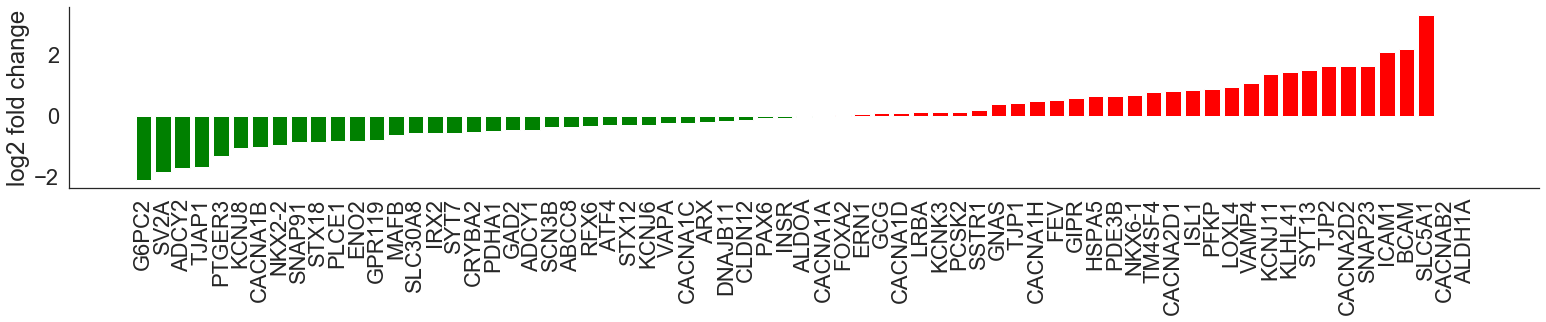

In [21]:
genes = ['ARX','FOXA2','IRX2','ISL1','MAFB','NKX2-2','NKX6-1','FEV','PAX6',
            'RFX6','GIPR','GPR119','INSR','SSTR1','ADCY1','ADCY2','GNAS',
            'PDE3B','ABCC8','KCNJ6','KCNJ8','KCNJ11','KCNK3','SCN3B','CACNA1A','CACNA1B','CACNA1C','CACNA1D','CACNA1H','CACNAB2',
            'CACNA2D1','CACNA2D2','ATF4','DNAJB11','ERN1','HSPA5','ALDOA','ENO2','G6PC2','PDHA1','PFKP','SLC5A1','GAD2','SLC30A8',
            'LRBA','SNAP23','SNAP91','STX12','STX18','SV2A','SYT13','SYT7','VAMP4','VAPA','BCAM','CLDN12','ICAM1','TJAP1','TJP1',
            'TJP2','GCG','ALDH1A','CRYBA2','KLHL41','LOXL4','PCSK2','PLCE1','PTGER3','TM4SF4']

def make_bulk_raw_sc(ds,columns_split=['DonorID','cell_type','DiabetesStatus'],n_min_cells=10):
    dict_diab = ds.split(columns_split)
    sum_cells ={}
    for key,ds in dict_diab.items():
        if ds.n_samples>n_min_cells:
            sum_cells[key]=  ds.counts.sum(axis=1)
    #concetenate dictionary to make df
    df = pd.concat(sum_cells, axis=1)
    df.columns = ['%s' % (a) for a in df.columns]
    df.fillna(0,inplace=True)
    df = df *1e6 /df.sum(axis=0)
    #df = np.log2(df+1)
    return df

sns.set(font_scale=2,style='white')
filter_condition = {'cell_type': ['alpha'],
                    'Patched': ['Yes'],
                    'DiabetesStatus':['cryo_healthy','cryo_T1D']}
filtered_dataset = filter_samplesheet(ds_pclamp_raw, filter_dict= filter_condition)


df_bulk_pclamp = make_bulk_raw_sc(filtered_dataset,columns_split=['DiabetesStatus'],n_min_cells=10)
df_bulk_pclamp['logFC']= np.log2(df_bulk_pclamp['cryo_T1D']/df_bulk_pclamp['cryo_healthy']+0.00001)



s_p = pd.DataFrame(df_bulk_pclamp.loc[genes,:], columns=['logFC'])
s_p =s_p.sort_values('logFC')
s_p['color'] ='green'
s_p.loc[s_p['logFC']>0,'color'] = 'red'
data =s_p['logFC'].fillna(0)
cdata=s_p['color']

fig,ax =plt.subplots(1,1,figsize=(22,5))
ind = np.arange(data.shape[0])
ax.bar(ind, data.values, color=cdata.values)
ax.set_xticks(ind)
ax.set_xticklabels(data.index,rotation=90)
ax.set_ylabel('log2 fold change')
plt.tight_layout()
sns.despine()
fig.savefig(fig_folder + 'SuppFig7E_pseudobulk.pdf')